In [2]:
import numpy as np
npa = np.array
import pandas as pd
import matplotlib.pylab as plt

from sklearn.decomposition import PCA

from IPython.display import display, clear_output

In [3]:
import pandas as pd
import matplotlib.pylab as plt

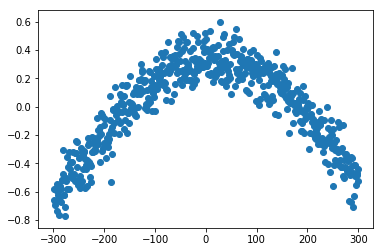

array([[  3.00500000e+04,   8.34025684e+00],
       [  8.34025684e+00,   9.50362350e-02]])

array([[  2.10500000e+02,   1.50000000e+00,   2.95000000e+01, ...,
          2.88500000e+02,  -1.80500000e+02,   2.50500000e+02],
       [ -8.55675518e-02,   4.06879842e-01,   1.80799555e-01, ...,
         -3.61606298e-01,  -1.82339434e-01,  -5.58950502e-01]])

In [129]:
x = np.arange(1,601)
y = np.sin(x / 200) + np.random.randn(len(x))*0.1
X = np.vstack((x,y))
X = (X.transpose() - X.transpose().mean(axis=0))[np.random.permutation(len(x))].transpose()
x, y = X

plt.scatter(x, y)
plt.show()

display(np.cov(X))
display(X)

hask


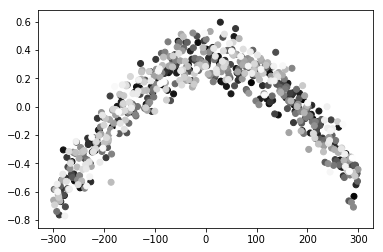

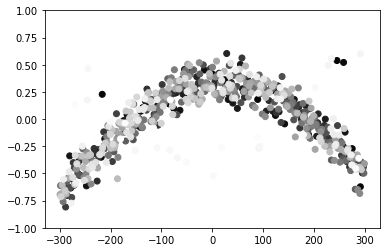

array([[  2.64375556e+04,  -1.22322274e-01],
       [ -1.22322274e-01,   4.95921838e-02]])

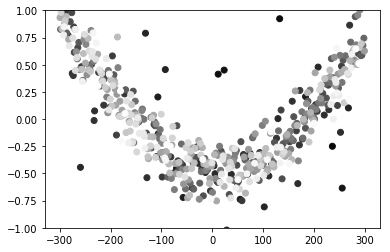

In [162]:
defv = 0.5 ** (1. / 600)

def calc_rotation_zero_not_first(h):
    h = np.array(h)
    
    # max axis to first position
    gci = np.argmax(np.abs(h))
    fmax_m = np.matrix(np.diag([1, 1, 1]))
    if gci != 0:
        fmax_m[0], fmax_m[gci] = np.matrix(fmax_m[gci]), np.matrix(fmax_m[0])
        fmax_m *= -1
    h = np.array(fmax_m * np.matrix(h).T).ravel()
    
    #make first axis positive
    fsign_m = np.matrix(np.diag([(1 if h[0] > 0 else -1)] * 2 + [1]))
    h = np.array(fsign_m * np.matrix(h).T).ravel()
    
    # zero second
    phi = np.arctan2(h[2], h[0])
    s, c = np.sin(phi), np.cos(phi)
    zero2nd_m = np.matrix(np.array([
        [c, 0, s],
        [0, 1, 0],
        [-s, 0, c],
    ]))
    h = np.array(zero2nd_m * np.matrix(h).T).ravel()
    
    # zero first
    phi = np.arctan2(h[1], h[0])
    s, c = np.sin(phi), np.cos(phi)
    zero1st_m = np.matrix(np.array([
        [c, s, 0],
        [-s, c, 0],
        [0, 0, 1],
    ]))
    h = np.array(zero1st_m * np.matrix(h).T).ravel()
    
    final_rotation = zero1st_m * zero2nd_m * fsign_m * fmax_m
    
    return final_rotation
    

def covi(x, y, avla=defv, covla = defv):
    mx = x[0]
    my = y[0]
    xx = 0
    yy = 0
    xy = 0
    nX = []
    nY = []
    for ix, iy in zip(x, y):
        mx = mx * avla + (1 - avla) * ix
        my = my * avla + (1 - avla) * iy
        xx = xx * covla + (1 - covla) * ((ix - mx) ** 2)
        yy = yy * covla + (1 - covla) * ((iy - my) ** 2)
        xy = xy * covla + (1 - covla) * ((ix - mx) * (iy - my))
    
        sd = ((xx - yy) ** 2 + 4 * (xy ** 2)) ** 0.5
        eval1 = (xx + yy - sd) / 2
        eval2 = (xx + yy + sd) / 2
        evec1 = np.array([-xy, xx - eval1])
        evec2 = np.array([-xy, xx - eval2])
        if abs(eval1) < abs(eval2):
            eva1, eval2 = eval2, eval1
            evec1, evec2 = evec2, evec1
            
        if evec1[0] * evec2[1] - evec1[1] * evec2[0] < 0:
            evec2 = -evec2
            
        #print(eval1, eval2)
        #print(evec1, evec2)
        m = np.matrix([evec1 / ((evec1 ** 2).sum() ** 0.5 + 1e-6), 
                       evec2 / ((evec2 ** 2).sum() ** 0.5 + 1e-6)]).T
        #print(m)
        det = np.linalg.det(m)
        #print(det)
        #print('DET', det)
        if not np.isfinite(det) or abs(abs(det) - 1) > 0.01:
            m = np.matrix([[1, 0], [0, 1]])
            print('hask')
        #X = np.stack([x, y], axis=1)
        X = np.matrix([[ix], [iy]])
        X = np.array(m.I * X)
        nx, ny = X
        nX.append(nx)
        nY.append(ny)

    
    return np.array([
        [xx, xy],
        [xy, yy]
    ]), np.array(nX), np.array(nY)

def covi3(zxy, avla=defv, rotla = 0.9, covla = defv):
    zxy = np.array(zxy)
    av = zxy[0]
    
    xx = 0
    yy = 0
    xy = 0
    
    rot = np.matrix.diagonal(np.ones(3).reshape((3, 1)))
    
    for i in range(len(zxy)):
        #print(av.shape, zxy.shape)
        av = av * avla + (1 - avla) * zxy[i]
        
        rot = rot * rotla + (1 - rotla) * calc_rotation_zero_not_first(av)
        
        zxy[i] = np.array(rot * np.matrix(zxy[i]).T).ravel()
        #continue
        av = np.array(rot * np.matrix(av).T).ravel()
        
        izxy = zxy[i]
        xx = xx * covla + (1 - covla) * ((izxy[1] - av[1]) ** 2)
        yy = yy * covla + (1 - covla) * ((izxy[2] - av[2]) ** 2)
        xy = xy * covla + (1 - covla) * ((izxy[1] - av[1]) * (izxy[2] - av[2]))
    
        sd = ((xx - yy) ** 2 + 4 * (xy ** 2)) ** 0.5
        eval1 = (xx + yy - sd) / 2
        eval2 = (xx + yy + sd) / 2
        evec1 = np.array([-xy, xx - eval1])
        evec2 = np.array([-xy, xx - eval2])
        if abs(eval1) < abs(eval2):
            eva1, eval2 = eval2, eval1
            evec1, evec2 = evec2, evec1
            
        if evec1[0] * evec2[1] - evec1[1] * evec2[0] < 0:
            evec2 = -evec2
            
        #print(eval1, eval2)
        #print(evec1, evec2)
        m = np.matrix([evec1 / ((evec1 ** 2).sum() ** 0.5 + 1e-6), 
                       evec2 / ((evec2 ** 2).sum() ** 0.5 + 1e-6)]).T
        #print(m)
        det = np.linalg.det(m)
        #print(det)
        #print('DET', det)
        if not np.isfinite(det) or abs(abs(det) - 1) > 0.01:
            m = np.matrix([[1, 0], [0, 1]])
            #print('hask')
        #X = np.stack([x, y], axis=1)
        X = np.matrix(zxy[i, 1:3].reshape((2, 1)))
        X = np.array(m.I * X)
        nx, ny = X
        zxy[i, 1:3] = nx, ny    
    return zxy

c, nx, ny = covi(x, y)


color = np.array([[a, a, a] for a in range(len(x))]) / len(x)

plt.scatter(x, y, c=color)
plt.show()

plt.scatter(nx, ny, c=color)
#plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

display(c)


nzxy = covi3(np.stack([x, y, y], axis=1)).transpose()
plt.scatter(nzxy[0], nzxy[1], c=color)
#plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

In [2]:
import glob, os
data_directory = 'arduino_data/'
!mkdir bin
!g++ -std=c++17 deviceDataParser.cpp -o ./bin/deviceDataParser
get_ipython().system("rm -r " + data_directory + "parsed")
get_ipython().system("mkdir " + data_directory + "parsed")

for file in glob.glob(data_directory + "D-?-????"):
    pfile = file.replace('/', '/parsed/')
    print(file, "-> ", pfile)
    get_ipython().system("bin/deviceDataParser < " + file + " " +
                         "1> " + pfile + " " + 
                         "2> /dev/null")

data_files = [file for file in glob.glob(data_directory + "parsed/*")]

mkdir: cannot create directory ‘bin’: File exists
arduino_data/D-4-0025 ->  arduino_data/parsed/D-4-0025
arduino_data/D-1-0041 ->  arduino_data/parsed/D-1-0041
arduino_data/D-5-0023 ->  arduino_data/parsed/D-5-0023
arduino_data/D-2-0031 ->  arduino_data/parsed/D-2-0031
arduino_data/D-1-0029 ->  arduino_data/parsed/D-1-0029
arduino_data/D-3-0033 ->  arduino_data/parsed/D-3-0033
arduino_data/D-6-0027 ->  arduino_data/parsed/D-6-0027


In [7]:
import re
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
!mkdir prepared_my_dataset

writable_X_files = [open("prepared_my_dataset/accel%s.txt" % s, 'w') for s in ['X', 'Y', 'Z']]
writable_y_file = open("prepared_my_dataset/activity.txt", 'w')

for file in data_files:
    t, num = map(int, re.findall(".*/D-(.)\-(....)", file)[0])
    if num > 34:
        continue
    X = pd.read_csv(file, header=None, index_col=0)[50:-50][[1, 2, 3]].values
    step = 128
    for start in range(0, len(X) - step, step * 3 // 2):
        x = X[start:start + step]
        for i in range(3):
            writable_X_files[i].write(
                " ".join(str(k) for k in x[:, i]) + "\n"
            )
        writable_y_file.write(str(t) + "\n")
    
for file in writable_X_files + [writable_y_file]:
    file.close()

mkdir: cannot create directory ‘prepared_my_dataset’: File exists


In [9]:
!head prepared_my_dataset/accelX.txt

!cat prepared_my_dataset/activity.txt

-10800 -10912 -10920 -10908 -10948 -10988 -10972 -10928 -11012 -11020 -11072 -11056 -10984 -11012 -11076 -11056 -10972 -10936 -10980 -10924 -10972 -10880 -10816 -10948 -10872 -10944 -11012 -10860 -10996 -11204 -11012 -10920 -10844 -10908 -11120 -11016 -11108 -11140 -11044 -11080 -10988 -11036 -11084 -11004 -10876 -10908 -10956 -10944 -11096 -10832 -10948 -10976 -11004 -10988 -11060 -11020 -10880 -10912 -10884 -11044 -11048 -11076 -11152 -11092 -11016 -11156 -11128 -11172 -11032 -10952 -10996 -11208 -11216 -11032 -10924 -10824 -10512 -11116 -11596 -11932 -11892 -11656 -11200 -11016 -11028 -11056 -11256 -11564 -11944 -11852 -11524 -11176 -10912 -11124 -11164 -11080 -11020 -11232 -11304 -11480 -11252 -11336 -11260 -11116 -11800 -11636 -11212 -11132 -11428 -11568 -11564 -11152 -11164 -11044 -10992 -11388 -11600 -11560 -11484 -11548 -11296 -11208 -11292 -11396 -11284 -11336 -11336 -11308
-11236 -11324 -11356 -11256 -11248 -11340 -11244 -11216 -11140 -11132 -11276 -11168 -11224 -11372 -11320

4
4
4
4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
5
5
5
2
2
2
2
2
2
2
1
1
1
3
3
3
3
3
3
6
6
6
6
6
6
6
6


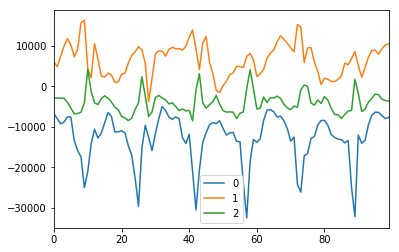

In [14]:
x = pd.read_csv('arduino_data/parsed/D-1-0041', header=None).values[10000:10100, 1:4]
pd.DataFrame(x).plot()
plt.show()